# Text clustering

In [29]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict
from sklearn import metrics

## Load data

In [2]:
with open("datasets/dutch_news_articles", "r") as f:
        
    titles = []
    texts = []
    categories = []
    
    temp_dict = {"title": [], "category": [], "text": []}

    for s in f.readlines()[23:25000]:
        
        # get stuff between quotes with regex
        s_between = s[s.find("'") + 1 : s.rfind("'")]
        s_outer = s.split(s_between)

        category = str(s_outer).split(",")[2]
        if len(category) < 15:
            categories.append(category)

            # turn into list, remove additional quotes and exclude date (first item)
            s_list = s_between.split("','")[1:]

            # store
            try:
                # titles.append(s_list[0])
                # texts.append(s_list[1])
                if s_list[0] and category and s_list[1]:
                    temp_dict["title"].append(s_list[0])
                    temp_dict["category"].append(category)
                    temp_dict["text"].append(s_list[1])
            except:
                # print(s_list)
                pass


In [3]:
df = pd.DataFrame.from_dict(temp_dict)
df

,title,category,text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...
...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...


In [4]:
# balance groups for better predictions
# df = df[~df.category.isin(["Koningshuis", "Economie"])]

In [5]:
category_sizes = df.groupby("category")["category"].count()
category_sizes

category
Binnenland      8234
Buitenland     10767
Economie        2208
Koningshuis      165
Politiek        3587
Name: category, dtype: int64

In [6]:
unique_labels = category_sizes.keys()
unique_labels

Index(['Binnenland', 'Buitenland', 'Economie', 'Koningshuis', 'Politiek'], dtype='object', name='category')

In [7]:
true_k = len(unique_labels)

## Preprocessing

### Cleaning

In [8]:
df

,title,category,text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...
...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...


In [9]:
df.text[0]

'De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centrale te sluiten in ruil voor toetreding tot de Europese Unie. De EU wilde sluiting omdat de kerncentrale bij de stad Visiginas mogelijk niet veilig was. Nucleaire ramp De centrale is een grotere versie van die bij Tsjernobyl. Die ontplofte in 1986 en veroorzaakte een nucleaire wolk die over een groot deel van Europa trok. Dat was de grootste nucleaire ramp in de geschiedenis. Voor Litouwen betekent de sluiting dat het land een goedkope bron van energie kwijt is. Het wordt nu veel afhankelijker van bijvoorbeeld gas uit Rusland. De kerncentrale leverde bijna driekwart van de Litouwse energiebehoefte.'

### Select stopwords to remove

In [10]:
# get list of dutch stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('dutch'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
stopwords_list

{'aan',
 'al',
 'alles',
 'als',
 'altijd',
 'andere',
 'ben',
 'bij',
 'daar',
 'dan',
 'dat',
 'de',
 'der',
 'deze',
 'die',
 'dit',
 'doch',
 'doen',
 'door',
 'dus',
 'een',
 'eens',
 'en',
 'er',
 'ge',
 'geen',
 'geweest',
 'haar',
 'had',
 'heb',
 'hebben',
 'heeft',
 'hem',
 'het',
 'hier',
 'hij',
 'hoe',
 'hun',
 'iemand',
 'iets',
 'ik',
 'in',
 'is',
 'ja',
 'je',
 'kan',
 'kon',
 'kunnen',
 'maar',
 'me',
 'meer',
 'men',
 'met',
 'mij',
 'mijn',
 'moet',
 'na',
 'naar',
 'niet',
 'niets',
 'nog',
 'nu',
 'of',
 'om',
 'omdat',
 'onder',
 'ons',
 'ook',
 'op',
 'over',
 'reeds',
 'te',
 'tegen',
 'toch',
 'toen',
 'tot',
 'u',
 'uit',
 'uw',
 'van',
 'veel',
 'voor',
 'want',
 'waren',
 'was',
 'wat',
 'werd',
 'wezen',
 'wie',
 'wil',
 'worden',
 'wordt',
 'zal',
 'ze',
 'zelf',
 'zich',
 'zij',
 'zijn',
 'zo',
 'zonder',
 'zou'}

### Lemmatization with SpaCy

In [12]:
# note: make sure library is downloaded -> in terminal: python -m spacy download nl_core_news_sm
import spacy
nlp = spacy.load("nl_core_news_sm")

In [13]:
texts = df.text

In [14]:
texts[0]

'De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centrale te sluiten in ruil voor toetreding tot de Europese Unie. De EU wilde sluiting omdat de kerncentrale bij de stad Visiginas mogelijk niet veilig was. Nucleaire ramp De centrale is een grotere versie van die bij Tsjernobyl. Die ontplofte in 1986 en veroorzaakte een nucleaire wolk die over een groot deel van Europa trok. Dat was de grootste nucleaire ramp in de geschiedenis. Voor Litouwen betekent de sluiting dat het land een goedkope bron van energie kwijt is. Het wordt nu veel afhankelijker van bijvoorbeeld gas uit Rusland. De kerncentrale leverde bijna driekwart van de Litouwse energiebehoefte.'

In [15]:
def lemmatizer(texts):
    """
    Bring words back to their root (lemma) using SpaCy Dutch pipeline.
    Note: avoid removing too much, some stopwords might be useful!
    """
    # remove enter (\n) after texts
    texts = [text.strip() for text in texts]

    # create spacy pipeline for nlp process
    docs = nlp.pipe(texts)

    # convert all texts into lists of lemmas and remove stopwords
    all_cleaned_lemmas = []
    for doc in docs:
        text_cleaned_lemmas = [text.lemma_ for text in doc if text.lemma_ not in stopwords_list]
        all_cleaned_lemmas.append(text_cleaned_lemmas)

    return all_cleaned_lemmas


cleaned_texts = lemmatizer(texts)
print(len(cleaned_texts), len(texts))

print(cleaned_texts[0], "\n\n", texts[0])

24961 24961
['enig', 'kerncentrale', 'Litouwen', 'oudjaarsavaan', '23.00', 'uur', 'buiten', 'gebruik', 'stellen', '.', 'verlopen', 'probleem', ',', 'aldus', 'directeur', '.', 'Litouwen', 'beloven', '2004', 'centraal', 'sluiten', 'ruil', 'toetreding', 'Europese', 'Unie', '.', 'EU', 'willen', 'sluiting', 'kerncentrale', 'stad', 'Visiginas', 'mogelijk', 'veilig', '.', 'nucleair', 'ramp', 'centrale', 'groot', 'versie', 'Tsjernobyl', '.', 'ontploffen', '1986', 'veroorzaken', 'nucleair', 'wolk', 'groot', 'deel', 'Europa', 'trekken', '.', 'groot', 'nucleair', 'ramp', 'geschiedenis', '.', 'Litouwen', 'betekenen', 'sluiting', 'land', 'goedkoop', 'bron', 'energie', 'kwijt', '.', 'afhankelijker', 'bijvoorbeeld', 'gas', 'Rusland', '.', 'kerncentrale', 'leveren', 'bijna', 'driekwart', 'Litouws', 'energiebehoefte', '.'] 

 De enige kerncentrale van Litouwen is oudjaarsavond om 23.00 uur buiten gebruik gesteld. Dat verliep zonder problemen, aldus de directeur. Litouwen beloofde al in 2004 om de centr

## Feature extraction
### TF-IDF vectorizing

In [16]:
texts = df.text
texts

0        De enige kerncentrale van Litouwen is oudjaars...
1        Spanje is met ingang van vandaag voorzitter va...
2        Vijf werknemers van het omstreden Amerikaanse ...
3        Het Oud en Nieuwfeest op het Museumplein in Am...
4        President Obama heeft de eerste rapporten gekr...
                               ...                        
24956    Een 18-jarige vrouw uit Hengelo die al twee ke...
24957    Aanstaand premier van Denenmarken Helle Thorni...
24958    Griekenland slaagt er dit en volgend jaar niet...
24959    Griekenland slaagt er niet in het begrotingste...
24960    Het ozonverlies boven de Noordpool is zo groot...
Name: text, Length: 24961, dtype: object

In [17]:
cleaned_texts[0]

['enig',
 'kerncentrale',
 'Litouwen',
 'oudjaarsavaan',
 '23.00',
 'uur',
 'buiten',
 'gebruik',
 'stellen',
 '.',
 'verlopen',
 'probleem',
 ',',
 'aldus',
 'directeur',
 '.',
 'Litouwen',
 'beloven',
 '2004',
 'centraal',
 'sluiten',
 'ruil',
 'toetreding',
 'Europese',
 'Unie',
 '.',
 'EU',
 'willen',
 'sluiting',
 'kerncentrale',
 'stad',
 'Visiginas',
 'mogelijk',
 'veilig',
 '.',
 'nucleair',
 'ramp',
 'centrale',
 'groot',
 'versie',
 'Tsjernobyl',
 '.',
 'ontploffen',
 '1986',
 'veroorzaken',
 'nucleair',
 'wolk',
 'groot',
 'deel',
 'Europa',
 'trekken',
 '.',
 'groot',
 'nucleair',
 'ramp',
 'geschiedenis',
 '.',
 'Litouwen',
 'betekenen',
 'sluiting',
 'land',
 'goedkoop',
 'bron',
 'energie',
 'kwijt',
 '.',
 'afhankelijker',
 'bijvoorbeeld',
 'gas',
 'Rusland',
 '.',
 'kerncentrale',
 'leveren',
 'bijna',
 'driekwart',
 'Litouws',
 'energiebehoefte',
 '.']

In [18]:
cleaned_texts_lower = [[x.lower() for x in text] for text in cleaned_texts]
len(cleaned_texts_lower), len(cleaned_texts)

(24961, 24961)

In [19]:
cleaned_texts_str = [' '.join(cleaned_text).split("https")[0] for cleaned_text in cleaned_texts_lower]
len(cleaned_texts_str)

24961

In [20]:
df["cleaned_text"] = cleaned_texts_str
df.head()

,title,category,text,cleaned_text
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...,enig kerncentrale litouwen oudjaarsavaan 23.00...
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...,spanje ingang vandaag voorzitter eu . zweeds p...
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...,vijf werknemer omstreden amerikaans beveilingi...
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...,oud nieuwfeest museumplein amsterdam tussen 40...
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...,president obama één rapport krijgen mislukken ...
...,...,...,...,...
24956,Hengelose blijft dreigtweets sturen,Binnenland,Een 18-jarige vrouw uit Hengelo die al twee ke...,18jarig vrouw hengelo twee keer eerder aanhoud...
24957,Deense premier heeft coalitie rond,Buitenland,Aanstaand premier van Denenmarken Helle Thorni...,aanstaand premier denenmarken helle thorning-s...
24958,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er dit en volgend jaar niet...,griekenland slagen volgen jaar begrotingstekor...
24959,Griekenland haalt EU/IMF-norm niet,Economie,Griekenland slaagt er niet in het begrotingste...,griekenland slagen begrotingstekort binnen twe...


In [21]:
# create vectorizer and set params
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    ngram_range=(1,3)
)

# fit vectorizer to data
t0 = time()
X_tfidf = vectorizer.fit_transform(df.cleaned_text)

print(f"vectorization took {time() - t0:.1f} sec for {len(texts)} texts\n")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 11.433 sec for 24961 texts

n_samples: 24961, n_features: 90447


In [22]:
vectorizer.get_feature_names()

['00',
 '00 11',
 '00 12',
 '00 12 00',
 '00 13',
 '00 13 00',
 '00 14',
 '00 14 00',
 '00 15',
 '00 17',
 '00 uur',
 '00 uur beginnen',
 '00 uur dicht',
 '00 uur gaan',
 '00 uur komen',
 '00 uur live',
 '00 uur lokaal',
 '00 uur moeten',
 '00 uur nacht',
 '00 uur nederland',
 '00 uur nederlands',
 '00 uur nos',
 '00 uur ochtends',
 '00 uur persconferentie',
 '00 uur plaatselijk',
 '00 uur rijden',
 '00 uur sluiten',
 '00 uur staan',
 '00 uur tijd',
 '00 uur uitzenden',
 '00 uur vanavond',
 '00 uur vanmiddag',
 '00 uur vannacht',
 '00 uur vanochtend',
 '00 uur vertrekken',
 '00 uur volgen',
 '00 uur weer',
 '00 uur zien',
 '00 uur zullen',
 '00 uur één',
 '000',
 '000 000',
 '000 100',
 '000 100 000',
 '000 15',
 '000 15 000',
 '000 20',
 '000 20 000',
 '000 200',
 '000 200 000',
 '000 500',
 '000 500 000',
 '000 agent',
 '000 agent straat',
 '000 ambtenaar',
 '000 amerikaan',
 '000 amerikaans',
 '000 amerikaans militair',
 '000 ander',
 '000 auto',
 '000 auto terug',
 '000 auto verkop

In [23]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape) :.3f}% of the entries in X_tfidf matrix are non-zero")

-0.001% of the entries in X_tfidf matrix are non-zero


In [24]:
X_tfidf

<24961x90447 sparse matrix of type '<class 'numpy.float64'>'
	with 2629711 stored elements in Compressed Sparse Row format>

## Clustering

### Note
KMeans is optimizing a non-convex objective function, therefore the clustering is not guaranteed to be optimal for random initiations. This can be seen below. Additionally, sparse high-dimensional data can lead to initialization of centroids on isolated data points. These data points stay their own centroids over iterations. Avoid this problem by increasing `n_init` -> increases number of runs with random initiation and chooses the best one

In [25]:
# random seeds determine outcome severely
for seed in range(5):

    # create and fit model
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=5,
        random_state=seed,
    ).fit(X_tfidf)

    # insights
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
    print()
print("True number of documents in each category according to the class labels: "
    f"{category_sizes}")

Number of elements assigned to each cluster: [ 4226 13318  2191  4568   658]

Number of elements assigned to each cluster: [ 2150  3467  3723 14885   736]

Number of elements assigned to each cluster: [  731  3690 15047  2052  3441]

Number of elements assigned to each cluster: [  743  3446  2199  4742 13831]

Number of elements assigned to each cluster: [15420  2169   651  3494  3227]

True number of documents in each category according to the class labels: category
Binnenland      8234
Buitenland     10767
Economie        2208
Koningshuis      165
Politiek        3587
Name: category, dtype: int64


### Elbow method for optimal k

In [ ]:
# elbow method for determining optimal cluster number
K = range(2,10)
sum_squared_errors = []

# vary the number of clusters
for k in K:

    # create and fit model
    kmeans = KMeans(
        n_clusters=k,
        max_iter=1000,
        n_init=15,
        random_state=seed,
    ).fit(X_tfidf)
    sum_squared_errors.append(kmeans.inertia_)

# plot the squared error per nr of clusters 
plt.plot(K, sum_squared_errors, 'bx-')
plt.xlabel('Nr of clusters k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method for optimal nr of clusters')
plt.show()


### Model evaluation

In [26]:
# evaluation metrics from sklearn
labels = df.category

def fit_and_evaluate(km, X, name=None, n_runs=5):
    evaluations = []
    evaluations_std = []
    train_times = []
    scores = defaultdict(list)

    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    train_times = np.asarray(train_times)
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [27]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
cluster_ids, cluster_sizes

(array([0, 1, 2, 3, 4]),
 array([15420,  2169,   651,  3494,  3227], dtype=int64))

Meaning evaluation scores: 
* all have a maximum value of 1.0 for perfect clustering
* adjusted rand-index -> 0 indicates random labeling

In [30]:
fit_and_evaluate(kmeans, X_tfidf, name="KMeans tf-idf vectors")

clustering done in 153.64 ± 8.12 s 
Homogeneity: 0.251 ± 0.030
Completeness: 0.262 ± 0.022
V-measure: 0.256 ± 0.026
Adjusted Rand-Index: 0.168 ± 0.040
Silhouette Coefficient: 0.003 ± 0.000


In [31]:
# Compute Silhoutte Score
ss = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_ , metric='euclidean')
ss

0.003060170050457631

## Dimensionality reduction and visualization

In [32]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X_tfidf.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [33]:
# assign clusters and pca vectors to our dataframe 
clusters = kmeans.labels_
df['cluster'] = clusters
df['x0'] = x0
df['x1'] = x1

In [44]:
df.head()

,title,category,text,cleaned_text,cluster,x0,x1
0,Enige Litouwse kerncentrale dicht,Buitenland,De enige kerncentrale van Litouwen is oudjaars...,enig kerncentrale litouwen oudjaarsavaan 23.00...,0,-0.007344,0.016264
1,Spanje eerste EU-voorzitter onder nieuw verdrag,Buitenland,Spanje is met ingang van vandaag voorzitter va...,spanje ingang vandaag voorzitter eu . zweeds p...,0,0.026739,0.032073
2,Fout justitie in Blackwater-zaak,Buitenland,Vijf werknemers van het omstreden Amerikaanse ...,vijf werknemer omstreden amerikaans beveilingi...,4,-0.038668,0.000153
3,"Museumplein vol, minder druk in Rotterdam",Binnenland,Het Oud en Nieuwfeest op het Museumplein in Am...,oud nieuwfeest museumplein amsterdam tussen 40...,0,-0.031008,0.037223
4,Obama krijgt rapporten over aanslag,Buitenland,President Obama heeft de eerste rapporten gekr...,president obama één rapport krijgen mislukken ...,0,-0.017528,-0.033781


In [35]:
print("Top words per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
nr_clusters = len(order_centroids)
words = vectorizer.get_feature_names()
for i in range(nr_clusters):
    print(f"Cluster: {i}", end="\n")
    for ind in order_centroids[i, :10]:
        print(words[ind])
    print()

Top terms per cluster:
Cluster: 0
zeggen
zullen
mens
jaar
komen
moeten
gaan
volgens
willen
president

Cluster: 1
pvv
cda
kabinet
wilders
vvd
partij
rutte
pvda
kamer
zeggen

Cluster: 2
kadhafi
libie
libisch
tripoli
opstandeling
navo
stad
opstandelingen
zeggen
kolonel

Cluster: 3
procent
euro
jaar
bank
miljoen
miljard
miljoen euro
moeten
gaan
miljard euro

Cluster: 4
man
politie
vrouw
twee
jaar
auto
verdenken
aanhouden
agent
jongen



In [36]:
# map clusters to labels
# note: dict(zip()) not working -> workaround
def convert(tuple, dictionary):
    for a, b in tuple:
        dictionary[a] = b
    return dictionary
     
dictionary = {}
mapping = list(zip(cluster_ids, unique_labels))
mapping = convert(mapping, dictionary)

In [ ]:
# apply mapping
df['cluster'] = df['cluster'].map(mapping)

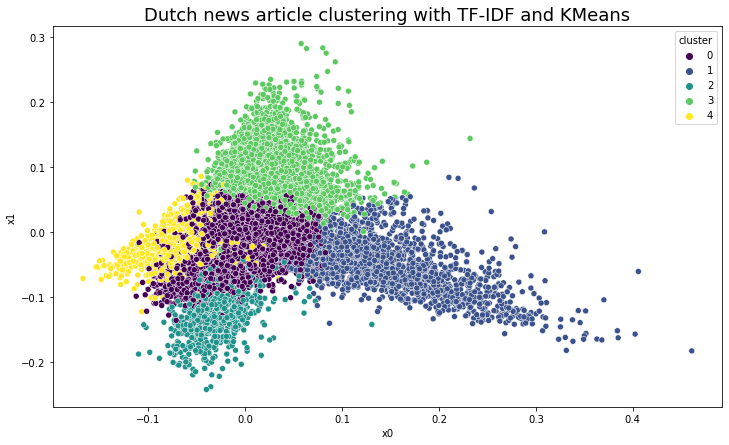

In [43]:
# cluster plotting
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.title("Dutch news article clustering with TF-IDF and KMeans", fontdict={"fontsize": 18})
plt.savefig("results/clustered_articles.png", dpi=300)
plt.show()

## Wordcloud

In [38]:
def word_cloud(text, cluster):

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopwords_list, 
                           min_font_size = 14).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (8, 6)) 
    
    # Set title for word cloud
    plt.title(f"Cluster {cluster}")
    
    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # show plot
    plt.show()

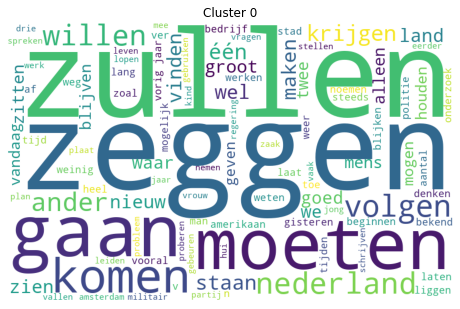

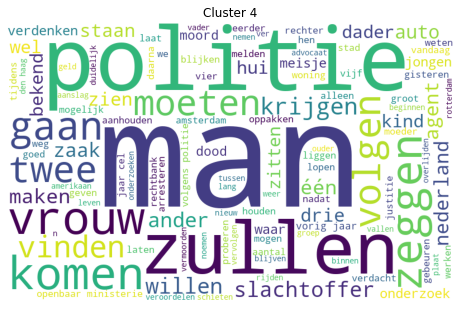

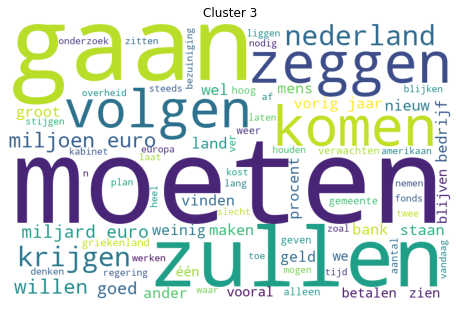

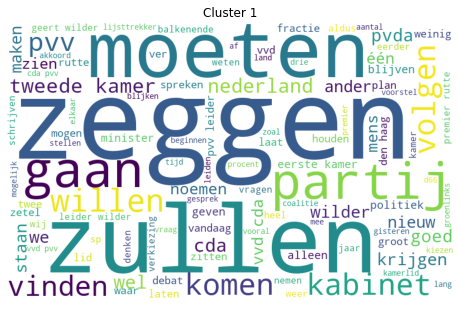

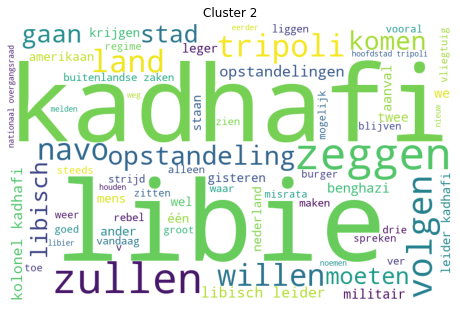

In [42]:
# plotting
for i in df.cluster.unique():
    texts_same_cluster = "".join(df[df.cluster == i].cleaned_text.tolist())
    word_cloud(texts_same_cluster, i)